In [1]:
from __future__ import print_function
from tqdm import tqdm_notebook
import numpy as np
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

1.11.0


In [2]:
tf.set_random_seed(2)

# Saving / Restoring  
    
    
## Saver and Session Object  
    
데이터를 파일 시스템에 영구적으로 저장하려면 TF는 **Saver** Object와 **Session** Object가 필요하다.  
     
**Saver** Object의 Constructor는 아래와 같다.  

```
__init__(
    var_list=None,
    reshape=False,
    sharded=False,
    max_to_keep=5,
    keep_checkpoint_every_n_hours=10000.0,
    name=None,
    restore_sequentially=False,
    saver_def=None,
    builder=None,
    defer_build=False,
    allow_empty=False,
    write_version=tf.train.SaverDef.V2,
    pad_step_number=False,
    save_relative_paths=False,
    filename=None
)
```  
    
- **var_list**는 파일시스템에 저장하는 변수의 리스트다
- 모든 변수를 저장할 수 있고, 몇몇의 변수만 저장할 수 있으며, 사용자가 직접 정의한 이름의 딕셔너리를 전달할 수도 있다.  
     
-------------
     
**Session** Constructor는 아래와 같다.
```
__init__(
    target='',
    graph=None,
    config=None
)
```  
    
- **target** : 분산 아키텍쳐 구조에서 어떤 계산을 처리할 때 사용한다. 특정 TF서버나 'target'을 정할 수 있다.
- **graph** : **Session** Object가 처리하는 그래프를 의미한다. 기본 파라미터는 default graph가 된다.
- **config** : **ConfigProto**를 입력으로 줄 수 있다. 자세한건 API document를 참조하자.
    
    
**Saver**는 **Graph**의 metadata와 **Variable** 데이터의 saving과 loading(restoring이라고 불린다)을 처리한다.
이를 위해서는 현재 Graph에서 평가될 수 있는 operation이 추가된다.  
    
     
**Saver**는 기본적으로 **default Graphe**를 처리하며, 모든 변수를 포함한다. 이는 사용자가 원하면, 따로 설정할 수 있다.

예제는 아래와 같다.
```
import tensorflow as tf

import os
dir = os.path.dirname(os.path.realpath(__file__))

# Currently, we are in the default graph scope

# Let's design some variables
v1 = tf.Variable(1. , name="v1")
v2 = tf.Variable(2. , name="v2")
# Let's design an operation
a = tf.add(v1, v2)

# We can check easily that we are indeed in the default graph
print(a.graph == tf.get_default_graph())
# -> True

# Let's create a Saver object
# By default, the Saver handles every Variables related to the default graph
all_saver = tf.train.Saver() 
# But you can precise which vars you want to save (as a list) and under which name (with a dict)
v2_saver = tf.train.Saver({"v2": v2}) 


# By default the Session handles the default graph and all its included variables
with tf.Session() as sess:
  # Init v1 and v2   
  sess.run(tf.global_variables_initializer())
  # Now v1 holds the value 1.0 and v2 holds the value 2.0
  # and we can save them
  all_saver.save(sess, dir + '/data-all')
  # or saves only v2
v2_saver.save(sess, dir + '/data-v2')
```
     
----
     
     
**Saver** Object를 통해서 저장하게되면, 해당 폴더에는 3가지 파일이 저장되고, `checkpoint`file이 생긴다.  
(자세한 내용은 따로 언급하겠다.)  
    
     
단순하게, 
- **.data**파일에는 weight파일이.  
- **.meta**파일에는 graph와 metadata파일이  
저장된다고 이해하면 된다.  
     
     
> **Saver**와 **Session**을 연결할 때, **Graph**가 **variables**을 포함하는지 확인해야한다.
> 아래 예제를 확인하자
    
```
import tensorflow as tf

g = tf.Graph()
with g.as_default():
    v1 = tf.Variable(5., dtype=tf.float32)
print(v1.graph == g)
# -> True
print(v1.graph == tf.get_default_graph())
# -> False

# The saver does not care in which part of the code it is constructed when given a list of variables
saver = tf.train.Saver([v1])

with tf.Session() as sess: 
    # The session handles the default graph which is NOT "g"
    sess.run(tf.global_variables_initializer())

    # This fails because "v1" is not in the default graph
saver.save(sess, 'test')
```
    
    

In [3]:
(x_train, y_train), (x_test , y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train/255).astype(np.float32).reshape(-1, 784)
x_test = (x_test/255).astype(np.float32).reshape(-1, 784)

val_range = int(len(x_test) * 0.8)

x_val = x_test[:val_range, :]
y_val = y_test[:val_range]

x_test = x_test[val_range:, :]
y_test = y_test[val_range:]

In [4]:
# Declare Input Node
x = tf.placeholder(dtype=tf.float32, name="Input")
y = tf.placeholder(dtype=tf.int32, name="Label")

# Declare parameter
layer1_weights = tf.Variable(initial_value=tf.truncated_normal([784, 500]) , dtype=tf.float32)
layer2_weights = tf.Variable(initial_value=tf.truncated_normal([500, 200]) , dtype=tf.float32)
layer3_weights = tf.Variable(initial_value=tf.truncated_normal([200, 10]) , dtype=tf.float32)

# build graph
feature1 = tf.matmul(x, layer1_weights)
activation1 = tf.tanh(feature1)
feature2 = tf.matmul(activation1, layer2_weights)
activation2 = tf.tanh(feature2)
score = tf.matmul(activation2, layer3_weights, name='score')

prediction = tf.argmax(input = score, axis=1)

tf.add_to_collection('input', x)
tf.add_to_collection('label', y)
tf.add_to_collection('score', score)

loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=score)

In [5]:
opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
optimizer = opt.minimize(loss)

# TensorBoard
softmaxLoss = tf.summary.scalar(name='softmax_loss', tensor=loss)
train_writer = tf.summary.FileWriter('./graphs/low-level/train_mnist_dnn', graph=tf.get_default_graph())
val_writer = tf.summary.FileWriter('./graphs/low-level/val_mnist_dnn', graph=tf.get_default_graph())

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V2)

# Hyper Parameter
epoch = 100
total_bar_length = tqdm_notebook(range(epoch))
batch_size=1024
total_step = int(x_train.shape[0] / batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_loss_hist = []
val_loss_hist = []

for i in total_bar_length:
    avg_train_loss = 0   
    avg_val_loss = 0 
    
    val_loss = 0
    
    train_loss_sum = 0    
    val_loss_sum = 0
    
    for step in range(total_step):
            batch_indices = np.random.choice(range(x_train.shape[0]), size=batch_size, replace=False)

            batch_xs = x_train[batch_indices]
            batch_ys = y_train[batch_indices]
            
            val_indices = np.random.choice(range(x_val.shape[0]), size=batch_size, replace=False)
            
            val_xs = x_val[val_indices]
            val_ys = y_val[val_indices]

            _, train_loss = sess.run([optimizer, loss], feed_dict={x:batch_xs, y:batch_ys})
            
            val_loss = sess.run(fetches = loss, feed_dict={x:val_xs, y:val_ys})
            
            avg_train_loss += train_loss / total_step
            avg_val_loss += val_loss / total_step
        
    train_loss_hist.append(avg_train_loss)
    val_loss_hist.append(val_loss)
    
    train_loss_sum = sess.run(softmaxLoss, feed_dict={x:batch_xs, y:batch_ys})
    val_loss_sum = sess.run(fetches = softmaxLoss, feed_dict={x:val_xs, y:val_ys})

    train_writer.add_summary(train_loss_sum, global_step = i)
    val_writer.add_summary(val_loss_sum, global_step = i)
        
train_writer.close()
val_writer.close()

global_step = tf.train.get_global_step()
saver.save(sess, './weights/mnist.ckpt', global_step=global_step)

print("train finished")

HBox(children=(IntProgress(value=0), HTML(value='')))


train finished


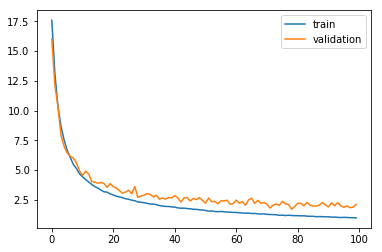

In [6]:
plt.plot(train_loss_hist, label="train")
plt.plot(val_loss_hist, label="validation")
plt.legend()
plt.show()

In [7]:
yhat = np.argmax(sess.run(score, feed_dict={x:x_test}), axis = 1)
print("acc : {:.2%}".format(np.mean(yhat == y_test)))

acc : 81.95%


# <span style="color:red">!!Kernel Restart!! </span>

## Restoring operations and other metadata  
    
실제 가중치는 **Session** object안에서만 존재한다.  
즉, `restore` 행위는 `Session`접근을 통해서 **Graph**에 복원할 수 있다는 이야기다.  
    
**Restore**의 간단한 예제는 아래와 같다.  
    

```
with tf.Session() as sess:
    # To initialize values with saved data
    saver.restore(sess, 'results/model.ckpt.data-1000-00000-of-00001')
print(sess.run(global_step_tensor)) # returns 1000
```

In [1]:
from __future__ import print_function
from tqdm import tqdm_notebook
import numpy as np
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

tf.set_random_seed(2)

(x_train, y_train), (x_test , y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train/255).astype(np.float32).reshape(-1, 784)
x_test = (x_test/255).astype(np.float32).reshape(-1, 784)

val_range = int(len(x_test) * 0.8)

x_val = x_test[:val_range, :]
y_val = y_test[:val_range]

x_test = x_test[val_range:, :]
y_test = y_test[val_range:]

# Declare Input Node
x = tf.placeholder(dtype=tf.float32, name="Input")
y = tf.placeholder(dtype=tf.int32, name="Label")

# Declare parameter
layer1_weights = tf.Variable(initial_value=tf.truncated_normal([784, 500]) , dtype=tf.float32)
layer2_weights = tf.Variable(initial_value=tf.truncated_normal([500, 200]) , dtype=tf.float32)
layer3_weights = tf.Variable(initial_value=tf.truncated_normal([200, 10]) , dtype=tf.float32)

# build graph
feature1 = tf.matmul(x, layer1_weights)
activation1 = tf.tanh(feature1)
feature2 = tf.matmul(activation1, layer2_weights)
activation2 = tf.tanh(feature2)
score = tf.matmul(activation2, layer3_weights, name='score')

prediction = tf.argmax(input = score, axis=1)

tf.add_to_collection('input', x)
tf.add_to_collection('label', y)
tf.add_to_collection('score', score)

loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=score)

opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
optimizer = opt.minimize(loss)

# TensorBoard
softmaxLoss = tf.summary.scalar(name='softmax_loss', tensor=loss)
train_writer = tf.summary.FileWriter('./graphs/low-level/train_mnist_dnn', graph=tf.get_default_graph())
val_writer = tf.summary.FileWriter('./graphs/low-level/val_mnist_dnn', graph=tf.get_default_graph())

sess = tf.Session()
saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V2)
saver.restore(sess, './weights/mnist.ckpt')

train_writer.close()
val_writer.close()

global_step = tf.train.get_global_step()


yhat = np.argmax(sess.run(score, feed_dict={x:x_test}), axis = 1)
print("acc : {:.2%}".format(np.mean(yhat == y_test)))

1.11.0
INFO:tensorflow:Restoring parameters from ./weights/mnist.ckpt
acc : 81.95%


# <span style="color:red">!!Kernel Restart!! </span>

# 삽질기......

![i am fasting](https://user-images.githubusercontent.com/13328380/52033706-37d4d680-2569-11e9-8fa9-014f3df5ac63.jpg)

In [1]:
from __future__ import print_function
from tqdm import tqdm_notebook
import numpy as np
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

tf.set_random_seed(2)
tf.reset_default_graph()

(x_train, y_train), (x_test , y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train/255).astype(np.float32).reshape(-1, 784)
x_test = (x_test/255).astype(np.float32).reshape(-1, 784)

val_range = int(len(x_test) * 0.8)

x_val = x_test[:val_range, :]
y_val = y_test[:val_range]

x_test = x_test[val_range:, :]
y_test = y_test[val_range:]

1.11.0


# Load Graph from `*.ckpt` file


In [2]:
saver = tf.train.import_meta_graph('./weights/mnist.ckpt.meta')
graph = tf.get_default_graph()
print(graph.get_operations())

[<tf.Operation 'Input' type=Placeholder>, <tf.Operation 'Label' type=Placeholder>, <tf.Operation 'truncated_normal/shape' type=Const>, <tf.Operation 'truncated_normal/mean' type=Const>, <tf.Operation 'truncated_normal/stddev' type=Const>, <tf.Operation 'truncated_normal/TruncatedNormal' type=TruncatedNormal>, <tf.Operation 'truncated_normal/mul' type=Mul>, <tf.Operation 'truncated_normal' type=Add>, <tf.Operation 'Variable' type=VariableV2>, <tf.Operation 'Variable/Assign' type=Assign>, <tf.Operation 'Variable/read' type=Identity>, <tf.Operation 'truncated_normal_1/shape' type=Const>, <tf.Operation 'truncated_normal_1/mean' type=Const>, <tf.Operation 'truncated_normal_1/stddev' type=Const>, <tf.Operation 'truncated_normal_1/TruncatedNormal' type=TruncatedNormal>, <tf.Operation 'truncated_normal_1/mul' type=Mul>, <tf.Operation 'truncated_normal_1' type=Add>, <tf.Operation 'Variable_1' type=VariableV2>, <tf.Operation 'Variable_1/Assign' type=Assign>, <tf.Operation 'Variable_1/read' type=

# Try inference only using `*ckpt` file

In [3]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.restore(sess, './weights/mnist.ckpt')

yhat = np.argmax(sess.run(score, feed_dict={x:x_test}), axis = 1)
print("acc : {:.2%}".format(np.mean(yhat == y_test)))

INFO:tensorflow:Restoring parameters from ./weights/mnist.ckpt


NameError: name 'score' is not defined

# ??????????

In [4]:
x = graph.get_operation_by_name("Input")
y = graph.get_operation_by_name("Label")
score = graph.get_operation_by_name("score")
print(x)
print(y)
print(score)

name: "Input"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      unknown_rank: true
    }
  }
}

name: "Label"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "shape"
  value {
    shape {
      unknown_rank: true
    }
  }
}

name: "score"
op: "MatMul"
input: "Tanh_1"
input: "Variable_2/read"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "transpose_a"
  value {
    b: false
  }
}
attr {
  key: "transpose_b"
  value {
    b: false
  }
}



# OH OH OH OH OH OH OH!!!

In [5]:
yhat = np.argmax(sess.run(score, feed_dict={x:x_test}), axis = 1)
print("acc : {:.2%}".format(np.mean(yhat == y_test)))

TypeError: Cannot interpret feed_dict key as Tensor: Can not convert a Operation into a Tensor.

![kk](https://user-images.githubusercontent.com/13328380/52034020-6bfcc700-256a-11e9-8f4d-8fac4116cfa2.jpeg)

In [6]:
x = graph.get_tensor_by_name("Input")
y = graph.get_tensor_by_name("Label")
score = graph.get_operation_by_name("score")

print(x)
print(y)
print(score)

ValueError: The name 'Input' refers to an Operation, not a Tensor. Tensor names must be of the form "<op_name>:<output_index>".

![296fd8b4a4928a1323396da3febad4a7](https://user-images.githubusercontent.com/13328380/52034060-964e8480-256a-11e9-9e1f-bc05bd0851f2.gif)

# tf.add_to_collection()

# <span style="color:red">!!Kernel Restart!! </span>

In [1]:
from __future__ import print_function
from tqdm import tqdm_notebook
import numpy as np
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

tf.set_random_seed(2)

1.11.0


In [2]:
(x_train, y_train), (x_test , y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train/255).astype(np.float32).reshape(-1, 784)
x_test = (x_test/255).astype(np.float32).reshape(-1, 784)

val_range = int(len(x_test) * 0.8)

x_val = x_test[:val_range, :]
y_val = y_test[:val_range]

x_test = x_test[val_range:, :]
y_test = y_test[val_range:]

In [3]:
# Declare Input Node
x = tf.placeholder(dtype=tf.float32, name="Input")
y = tf.placeholder(dtype=tf.int32, name="Label")

# Declare parameter
layer1_weights = tf.Variable(initial_value=tf.truncated_normal([784, 500]) , dtype=tf.float32)
layer2_weights = tf.Variable(initial_value=tf.truncated_normal([500, 200]) , dtype=tf.float32)
layer3_weights = tf.Variable(initial_value=tf.truncated_normal([200, 10]) , dtype=tf.float32)

# build graph
feature1 = tf.matmul(x, layer1_weights)
activation1 = tf.tanh(feature1)
feature2 = tf.matmul(activation1, layer2_weights)
activation2 = tf.tanh(feature2)
score = tf.matmul(activation2, layer3_weights, name='score')

prediction = tf.argmax(input = score, axis=1)

loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=score)

# tf.add_to_collection() 으로 넣어주자!!!

In [4]:
tf.add_to_collection('input', x)
tf.add_to_collection('label', y)
tf.add_to_collection('score', score)

In [5]:
opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
optimizer = opt.minimize(loss)

# TensorBoard
softmaxLoss = tf.summary.scalar(name='softmax_loss', tensor=loss)
train_writer = tf.summary.FileWriter('./graphs/low-level/train_mnist_dnn', graph=tf.get_default_graph())
val_writer = tf.summary.FileWriter('./graphs/low-level/val_mnist_dnn', graph=tf.get_default_graph())

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V2)

# Hyper Parameter
epoch = 100
total_bar_length = tqdm_notebook(range(epoch))
batch_size=1024
total_step = int(x_train.shape[0] / batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_loss_hist = []
val_loss_hist = []

for i in total_bar_length:
    avg_train_loss = 0   
    avg_val_loss = 0 
    
    val_loss = 0
    
    train_loss_sum = 0    
    val_loss_sum = 0
    
    for step in range(total_step):
            batch_indices = np.random.choice(range(x_train.shape[0]), size=batch_size, replace=False)

            batch_xs = x_train[batch_indices]
            batch_ys = y_train[batch_indices]
            
            val_indices = np.random.choice(range(x_val.shape[0]), size=batch_size, replace=False)
            
            val_xs = x_val[val_indices]
            val_ys = y_val[val_indices]

            _, train_loss = sess.run([optimizer, loss], feed_dict={x:batch_xs, y:batch_ys})
            
            val_loss = sess.run(fetches = loss, feed_dict={x:val_xs, y:val_ys})
            
            avg_train_loss += train_loss / total_step
            avg_val_loss += val_loss / total_step
        
    train_loss_hist.append(avg_train_loss)
    val_loss_hist.append(val_loss)
    
    train_loss_sum = sess.run(softmaxLoss, feed_dict={x:batch_xs, y:batch_ys})
    val_loss_sum = sess.run(fetches = softmaxLoss, feed_dict={x:val_xs, y:val_ys})

    train_writer.add_summary(train_loss_sum, global_step = i)
    val_writer.add_summary(val_loss_sum, global_step = i)
        
train_writer.close()
val_writer.close()

global_step = tf.train.get_global_step()
saver.save(sess, './weights/mnist.ckpt', global_step=global_step)

print("train finished")

HBox(children=(IntProgress(value=0), HTML(value='')))


train finished


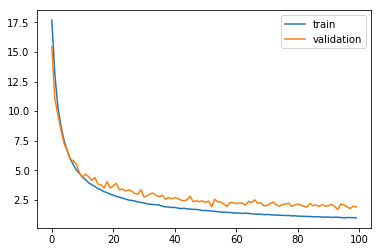

In [6]:
plt.plot(train_loss_hist, label="train")
plt.plot(val_loss_hist, label="validation")
plt.legend()
plt.show()

In [7]:
yhat = np.argmax(sess.run(score, feed_dict={x:x_test}), axis = 1)
print("acc : {:.2%}".format(np.mean(yhat == y_test)))

acc : 82.30%


# Try Again!

# <span style="color:red">!!Kernel Restart!! </span>

In [1]:
from __future__ import print_function
from tqdm import tqdm_notebook
import numpy as np
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

1.11.0


In [2]:
tf.set_random_seed(2)
tf.reset_default_graph()

In [3]:
(x_train, y_train), (x_test , y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train/255).astype(np.float32).reshape(-1, 784)
x_test = (x_test/255).astype(np.float32).reshape(-1, 784)

val_range = int(len(x_test) * 0.8)

x_val = x_test[:val_range, :]
y_val = y_test[:val_range]

x_test = x_test[val_range:, :]
y_test = y_test[val_range:]

saver = tf.train.import_meta_graph('./weights/mnist.ckpt.meta')
graph = tf.get_default_graph()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.restore(sess, './weights/mnist.ckpt')
x = tf.get_collection("input")[0]
y = tf.get_collection("label")[0]
score = tf.get_collection("score")[0]

yhat = np.argmax(sess.run(score, feed_dict={x:x_test}), axis = 1)
print("acc : {:.2%}".format(np.mean(yhat == y_test)))

INFO:tensorflow:Restoring parameters from ./weights/mnist.ckpt
acc : 82.30%


![gvsc 1](https://user-images.githubusercontent.com/13328380/52034324-779cbd80-256b-11e9-9df1-3bb7411918c8.png)

# Other Way

In [1]:
from __future__ import print_function
from tqdm import tqdm_notebook
import numpy as np
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

tf.set_random_seed(2)
tf.reset_default_graph()

(x_train, y_train), (x_test , y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train/255).astype(np.float32).reshape(-1, 784)
x_test = (x_test/255).astype(np.float32).reshape(-1, 784)

val_range = int(len(x_test) * 0.8)

x_val = x_test[:val_range, :]
y_val = y_test[:val_range]

x_test = x_test[val_range:, :]
y_test = y_test[val_range:]

1.11.0


In [2]:
saver = tf.train.import_meta_graph('./weights/mnist.ckpt.meta')
graph = tf.get_default_graph()
for op in graph.get_operations():
    print(op.name)

Input
Label
truncated_normal/shape
truncated_normal/mean
truncated_normal/stddev
truncated_normal/TruncatedNormal
truncated_normal/mul
truncated_normal
Variable
Variable/Assign
Variable/read
truncated_normal_1/shape
truncated_normal_1/mean
truncated_normal_1/stddev
truncated_normal_1/TruncatedNormal
truncated_normal_1/mul
truncated_normal_1
Variable_1
Variable_1/Assign
Variable_1/read
truncated_normal_2/shape
truncated_normal_2/mean
truncated_normal_2/stddev
truncated_normal_2/TruncatedNormal
truncated_normal_2/mul
truncated_normal_2
Variable_2
Variable_2/Assign
Variable_2/read
MatMul
Tanh
MatMul_1
Tanh_1
score
ArgMax/dimension
ArgMax
sparse_softmax_cross_entropy_loss/remove_squeezable_dimensions/Rank
sparse_softmax_cross_entropy_loss/remove_squeezable_dimensions/Rank_1
sparse_softmax_cross_entropy_loss/remove_squeezable_dimensions/sub
sparse_softmax_cross_entropy_loss/remove_squeezable_dimensions/Equal/x
sparse_softmax_cross_entropy_loss/remove_squeezable_dimensions/Equal
sparse_softm

In [3]:
x = graph.get_tensor_by_name("Input:0")
y = graph.get_tensor_by_name("Label:0")
score = graph.get_tensor_by_name("score:0")

print(x)
print(y)
print(score)

Tensor("Input:0", dtype=float32)
Tensor("Label:0", dtype=int32)
Tensor("score:0", shape=(?, 10), dtype=float32)


In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.restore(sess, './weights/mnist.ckpt')

yhat = np.argmax(sess.run(score, feed_dict={x:x_test}), axis = 1)
print("acc : {:.2%}".format(np.mean(yhat == y_test)))

INFO:tensorflow:Restoring parameters from ./weights/mnist.ckpt
acc : 82.30%


# 원래 이거 보여줄라고 한거 아니였는데.....

![225b973a53b2c87e1e](https://user-images.githubusercontent.com/13328380/52034402-bd598600-256b-11e9-9ae9-6a30d6e0c2dc.png)

# <span style="color:red">!!Kernel Restart!! </span>

## Original Freeze_graph function

In [1]:
from __future__ import print_function
import os, argparse
from tqdm import tqdm_notebook
import numpy as np
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

tf.set_random_seed(2)

1.11.0


In [2]:
(x_train, y_train), (x_test , y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train/255).astype(np.float32).reshape(-1, 784)
x_test = (x_test/255).astype(np.float32).reshape(-1, 784)

val_range = int(len(x_test) * 0.8)

x_val = x_test[:val_range, :]
y_val = y_test[:val_range]

x_test = x_test[val_range:, :]
y_test = y_test[val_range:]

In [3]:
# The original freeze_graph function
# from tensorflow.python.tools.freeze_graph import freeze_graph 
def freeze_graph(model_dir, output_node_names):
    """Extract the sub graph defined by the output nodes and convert 
    all its variables into constant 
    Args:
        model_dir: the root folder containing the checkpoint state file
        output_node_names: a string, containing all the output node's names, 
                            comma separated
    """
    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            "directory: %s" % model_dir)

    if not output_node_names:
        print("You need to supply the name of a node to --output_node_names.")
        return -1

    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_dir)
    print("checkpoint : {}".format(checkpoint))
    input_checkpoint = checkpoint.model_checkpoint_path
    print("input_checkpoint : {}".format(input_checkpoint))
    
    # We precise the file fullname of our freezed graph
    absolute_model_dir = "/".join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + "/frozen_model.pb"
    print("absolute_model_dir : {}".format(absolute_model_dir))

    # We clear devices to allow TensorFlow to control on which device it will load operations
    clear_devices = True

    # We start a session using a temporary fresh Graph
    with tf.Session(graph=tf.Graph()) as sess:
        # We import the meta graph in the current default Graph
        saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

        # We restore the weights
        saver.restore(sess, input_checkpoint)

        # We use a built-in TF helper to export variables to constants
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
            output_node_names.split(",") # The output node names are used to select the usefull nodes
        ) 

        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
        print("%d ops in the final graph." % len(output_graph_def.node))

    return output_graph_def

In [4]:
# Declare Input Node
x = tf.placeholder(dtype=tf.float32, name="Input")
y = tf.placeholder(dtype=tf.int32, name="Label")

# Declare parameter
layer1_weights = tf.Variable(initial_value=tf.truncated_normal([784, 500]) , dtype=tf.float32, name="weights1")
layer2_weights = tf.Variable(initial_value=tf.truncated_normal([500, 200]) , dtype=tf.float32, name="weights2")
layer3_weights = tf.Variable(initial_value=tf.truncated_normal([200, 10]) , dtype=tf.float32, name="weights3")

# build graph
feature1 = tf.matmul(x, layer1_weights, name="feature1")
activation1 = tf.tanh(feature1, name="activation1")
feature2 = tf.matmul(activation1, layer2_weights, name="feature2")
activation2 = tf.tanh(feature2, name="activation2")
score = tf.matmul(activation2, layer3_weights, name='score')

prediction = tf.argmax(input = score, axis=1, name='prediction')

loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=score)

tf.add_to_collection('input', x)
tf.add_to_collection('label', y)
tf.add_to_collection('score', score)

opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
optimizer = opt.minimize(loss)

# TensorBoard
softmaxLoss = tf.summary.scalar(name='softmax_loss', tensor=loss)
train_writer = tf.summary.FileWriter('./graphs/low-level/train_mnist_dnn', graph=tf.get_default_graph())
val_writer = tf.summary.FileWriter('./graphs/low-level/val_mnist_dnn', graph=tf.get_default_graph())

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V2)

# Hyper Parameter
epoch = 100
total_bar_length = tqdm_notebook(range(epoch))
batch_size=1024
total_step = int(x_train.shape[0] / batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_loss_hist = []
val_loss_hist = []

for i in total_bar_length:
    avg_train_loss = 0   
    avg_val_loss = 0 
    
    val_loss = 0
    
    train_loss_sum = 0    
    val_loss_sum = 0
    
    for step in range(total_step):
            batch_indices = np.random.choice(range(x_train.shape[0]), size=batch_size, replace=False)

            batch_xs = x_train[batch_indices]
            batch_ys = y_train[batch_indices]
            
            val_indices = np.random.choice(range(x_val.shape[0]), size=batch_size, replace=False)
            
            val_xs = x_val[val_indices]
            val_ys = y_val[val_indices]

            _, train_loss = sess.run([optimizer, loss], feed_dict={x:batch_xs, y:batch_ys})
            
            val_loss = sess.run(fetches = loss, feed_dict={x:val_xs, y:val_ys})
            
            avg_train_loss += train_loss / total_step
            avg_val_loss += val_loss / total_step
        
    train_loss_hist.append(avg_train_loss)
    val_loss_hist.append(val_loss)
    
    train_loss_sum = sess.run(softmaxLoss, feed_dict={x:batch_xs, y:batch_ys})
    val_loss_sum = sess.run(fetches = softmaxLoss, feed_dict={x:val_xs, y:val_ys})

    train_writer.add_summary(train_loss_sum, global_step = i)
    val_writer.add_summary(val_loss_sum, global_step = i)
        
train_writer.close()
val_writer.close()

global_step = tf.train.get_global_step()
saver.save(sess, './weights/mnist.ckpt', global_step=global_step)

freeze_graph(model_dir="./weights/", output_node_names="Input,Label,feature1,activation1,feature2,activation2,score")

print("train finished")

HBox(children=(IntProgress(value=0), HTML(value='')))


checkpoint : model_checkpoint_path: "./weights/mnist.ckpt"
all_model_checkpoint_paths: "./weights/mnist.ckpt"

input_checkpoint : ./weights/mnist.ckpt
absolute_model_dir : ./weights
INFO:tensorflow:Restoring parameters from ./weights/mnist.ckpt
INFO:tensorflow:Froze 3 variables.
INFO:tensorflow:Converted 3 variables to const ops.
13 ops in the final graph.
train finished


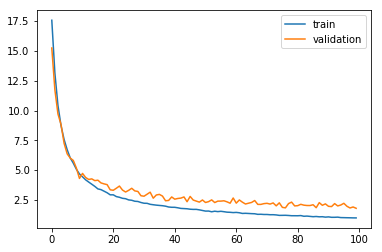

In [5]:
plt.plot(train_loss_hist, label="train")
plt.plot(val_loss_hist, label="validation")
plt.legend()
plt.show()

In [6]:
yhat = np.argmax(sess.run(score, feed_dict={x:x_test}), axis = 1)
print("acc : {:.2%}".format(np.mean(yhat == y_test)))

acc : 82.25%


In [7]:
!ls weights

checkpoint	 mnist.ckpt.data-00000-of-00001  mnist.ckpt.meta
frozen_model.pb  mnist.ckpt.index


# <span style="color:red">!!Kernel Restart!! </span>

# How to use the frozen model  
    
Model을 Freeze했다면, 이제 어떻게 사용할 수 있는가만 고민하면 된다.  
      
     
어떻게 사용하느냐에 대한 이야기는 어떤방식으로 model이 load되는지를 생각하면된다.
- graph_def ProtoBuf를 먼저 Import한다.
- graph_def을 이용하여 실제 Graph를 load한다.

In [1]:
from __future__ import print_function
import os, argparse
from tqdm import tqdm_notebook
import numpy as np
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

tf.set_random_seed(2)

1.11.0


In [2]:
(x_train, y_train), (x_test , y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train/255).astype(np.float32).reshape(-1, 784)
x_test = (x_test/255).astype(np.float32).reshape(-1, 784)

val_range = int(len(x_test) * 0.8)

x_val = x_test[:val_range, :]
y_val = y_test[:val_range]

x_test = x_test[val_range:, :]
y_test = y_test[val_range:]

In [3]:
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="prefix")
    return graph

In [4]:
graph = load_graph("./weights/frozen_model.pb")

for op in graph.get_operations():
    print(op.name)

prefix/Input
prefix/Label
prefix/weights1
prefix/weights1/read
prefix/weights2
prefix/weights2/read
prefix/weights3
prefix/weights3/read
prefix/feature1
prefix/activation1
prefix/feature2
prefix/activation2
prefix/score


In [5]:
x = graph.get_tensor_by_name("prefix/Input:0")
y = graph.get_tensor_by_name("prefix/Label:0")
score = graph.get_tensor_by_name("prefix/score:0")

with tf.Session(graph=graph) as sess:
    yhat = np.argmax(sess.run(score, feed_dict={x:x_test}), axis = 1)
    print("acc : {:.2%}".format(np.mean(yhat == y_test)))

acc : 82.25%


## Reference  
    

[[1]. TensorFlow: saving/restoring and mixing multiple models](https://blog.metaflow.fr/tensorflow-saving-restoring-and-mixing-multiple-models-c4c94d5d7125)  
[[2]. TensorFlow: How to freeze a model and serve it with a python API](https://blog.metaflow.fr/tensorflow-how-to-freeze-a-model-and-serve-it-with-a-python-api-d4f3596b3adc)